In [1]:
import numpy as np
import pandas as pd
import sys
sys.path.append('../')
import matplotlib.pyplot as plt
from pyrrhenious import database
from pyrrhenious import utils as pyrutils
import checking_author as check_auth
file = '../publication_database.csv'

ecdatabase = database.Database(file)
ecdatabase.load_models()
phases = ecdatabase.get_phases()
model_names = ecdatabase.get_model_list_for_phase('oomphacite')
model_names

/Volumes/MT_RESEARCH/2D_Petrology/mineral_conductivity/mineralconductivities/ensembles/../pyrrhenious/database.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subframe['grouping_id'] = subframe['entry_id'].str.slice(stop=-5)


['Zhang_19_oomph', 'Liu_19_oomph']

# Exploring Pyrrhenious's Wadsleyite Ensembles

Here we look at Wadsleyite models parameterization correspondence of:

 * Yoshino et al., 2008. Dry mantle transition zone inferred from the conductivity of wadsleyite and ringwoodite

 * Takashi Yoshino and Tomoo Katsura 2012. Re-evaluation of electrical conductivity of anhydrous and hydrous wadsleyite
  
 * Sun et al., 2018. Supercritical fluid in the mantle transition zone deduced from H–D interdiffusion of wadsleyite
 
In order to match the results of Yoshino and Katusra 2012, The small polaron conduction enthalpy had to be increased from 1.45 to 1.5, the water exponent in proton conduction was set to one, and the alpha value in the exponent had to be increased from 0.02 to 0.2. Sun et al. 2018 also had significant revisions to the preexponential constants and enthalpy in order to match both the diffusion and conductivity data, albeit within the stdev reported.

## Dry Trends

Only the models of Yoshino et al., 2008 and Yoshino and Katsura 2012 are used for dry. Sun et al., 2018 used Yoshino 2008's dry polaron conduction as a basis for dry conductivity, so the Sun result is not applicable

Text(0, 0.5, 'log10(sigma)')

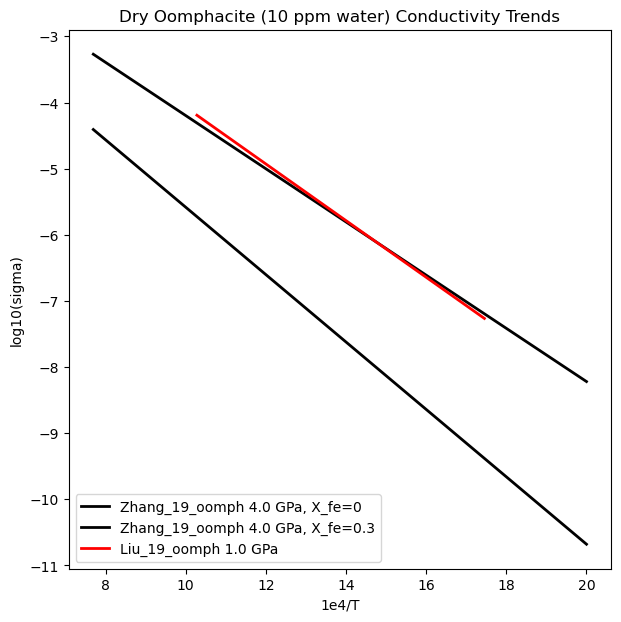

In [13]:
import matplotlib.cm as cm
model_names = ecdatabase.get_model_list_for_phase('oomphacite')
fix, ax = plt.subplots(figsize=(7,7))
for i, model in enumerate(filter(lambda x : 'Zhang' in x, model_names)):
    ec_model_row = ecdatabase.get_model_properties(model)
    ec_model     = ecdatabase.get_model(model)
    temperature_range = np.linspace(ec_model_row['temp_mink'],
                                    ec_model_row['temp_maxk'],num=100,dtype=float).ravel()
    pressure = ec_model_row['pressure_average_gpa'].values[0]
    for iron in [0,0.3]:    
        if pressure< 0.001:
            pressure = 0
        ax.plot(1e4/temperature_range,
            np.log10(ec_model.get_conductivity(T=temperature_range,Cw=10,X_fe=iron)),
            linewidth=2,label=model+f' {pressure} GPa, X_fe={iron}',color='black')

for i, model in enumerate(filter(lambda x : 'Liu' in x, model_names)):
    
    ec_model_row = ecdatabase.get_model_properties(model)
    ec_model     = ecdatabase.get_model(model)
    temperature_range = np.linspace(ec_model_row['temp_mink'],
                                    ec_model_row['temp_maxk'],num=100,dtype=float).ravel()
    pressure = ec_model_row['pressure_average_gpa'].values[0]
        
    if pressure< 0.001:
        pressure = 0
    ax.plot(1e4/temperature_range,
            np.log10(ec_model.get_conductivity(T=temperature_range,Cw=10)),
            linewidth=2,label=model+f' {pressure} GPa',color='red')
    

plt.legend(loc='lower left')
plt.title('Dry Oomphacite (10 ppm water) Conductivity Trends')
plt.xlabel('1e4/T')
plt.ylabel('log10(sigma)')


In [32]:
temperature_range_extended = np.linspace(500,1500,num=1300-500+1,dtype=float).ravel()

for i, model in enumerate(filter(lambda x : 'Zhang' in x, model_names)):
    ec_model_row = ecdatabase.get_model_properties(model)
    ec_model     = ecdatabase.get_model(model)
    temperature_range_1 = np.arange(int(ec_model_row['temp_mink'].values[0]),
                                    int(ec_model_row['temp_maxk'].values[0])+1,1,dtype=float).ravel()
    ec1 = ec_model.get_conductivity(T=temperature_range_1,Cw=10,X_fe=0)
    ec2 = ec_model.get_conductivity(T=temperature_range_1,Cw=10,X_fe=0.3)
    ec1_ext = ec_model.get_conductivity(T=temperature_range_extended,Cw=10,X_fe=0)
    ec2_ext = ec_model.get_conductivity(T=temperature_range_extended,Cw=10,X_fe=0.3)
    
    df1=pd.Series(ec1,index = temperature_range_1,name='zh_1')
    df2=pd.Series(ec2,index = temperature_range_1,name='zh_2')
    zhang_within      = pd.concat([df1,df2],axis=1)
    df1=pd.Series(ec1_ext,index = temperature_range_extended,name='zh_3')
    df2=pd.Series(ec2_ext,index = temperature_range_extended,name='zh_4')
    zhang_extrapolate      = pd.concat([df1,df2],axis=1)
    
for i, model in enumerate(filter(lambda x : 'Liu' in x, model_names)):
    
    ec_model_row = ecdatabase.get_model_properties(model)
    ec_model     = ecdatabase.get_model(model)
    temperature_range_2 = np.arange(int(ec_model_row['temp_mink'].values[0]),
                                    int(ec_model_row['temp_maxk'].values[0])+1,dtype=float).ravel()
    ec2 = ec_model.get_conductivity(T=temperature_range_2,Cw=10)
    ec2_ext = ec_model.get_conductivity(T=temperature_range_extended,Cw=10)
    y12_within      = pd.Series(ec2,index = temperature_range_2,name='liu')
    y12_extrapolate = pd.Series(ec2_ext,index = temperature_range_extended,name='liu_ex')


In [33]:
within_experiments = np.log10(pd.concat([zhang_within,y12_within],axis=1).sort_index())
extrapolated = np.log10(pd.concat([zhang_extrapolate,y12_extrapolate],axis=1).sort_index())
extrapolated

,zh_3,zh_4,liu_ex
500.00,-10.679732,-8.219833,-8.356615
501.25,-10.654319,-8.199773,-8.335252
502.50,-10.629032,-8.179814,-8.313995
503.75,-10.603870,-8.159953,-8.292844
505.00,-10.578833,-8.140190,-8.271797
...,...,...,...
1495.00,-3.897178,-2.866182,-2.655089
1496.25,-3.894330,-2.863934,-2.652695
1497.50,-3.891488,-2.861691,-2.650305
1498.75,-3.888650,-2.859451,-2.647920


In [34]:
within_experiments.sort_index(inplace=True)
within_experiments

,zh_1,zh_2,liu
500.0,-10.679732,-8.219833,NaN
501.0,-10.659391,-8.203777,NaN
502.0,-10.639131,-8.187786,NaN
503.0,-10.618952,-8.171857,NaN
504.0,-10.598853,-8.155992,NaN
...,...,...,...
1296.0,-4.420523,-3.279272,NaN
1297.0,-4.417492,-3.276880,NaN
1298.0,-4.414465,-3.274490,NaN
1299.0,-4.411443,-3.272105,NaN


## Wet vs Dry Oomphacite Trends

/var/folders/5h/95y6jy4s2pb02h07pf5q7dgc0000gn/T/ipykernel_68774/2760441226.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color=cm.get_cmap('cool_r')(i/(len(water)+1)))
/var/folders/5h/95y6jy4s2pb02h07pf5q7dgc0000gn/T/ipykernel_68774/2760441226.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color=cm.get_cmap('cool_r')(i/(len(water)+1)))
/var/folders/5h/95y6jy4s2pb02h07pf5q7dgc0000gn/T/ipykernel_68774/2760441226.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  

Text(0, 0.5, 'log10(sigma)')

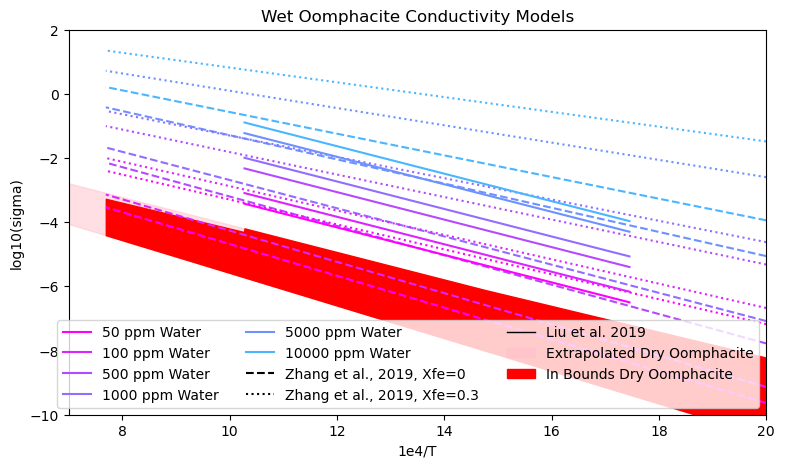

In [37]:
fix, ax = plt.subplots(figsize=(9,5))
water = [50,100,500,1000,5000,10000]
for model in model_names:
    ec_model_row = ecdatabase.get_model_properties(model)
    ec_model = ecdatabase.get_model(model)
    temperature_range = np.linspace(ec_model_row['temp_mink'],
                                    ec_model_row['temp_maxk'],num=100,dtype=float).ravel()
    if 'Zhang' in model:
        for iron,linestyle in zip([0,0.3],['--',':']):  
            for i, ppm_h2o in enumerate(water):
                c = ec_model.get_conductivity(T=temperature_range,Cw=ppm_h2o,co2=0,X_fe=iron)
                ax.plot(1e4/temperature_range,
                np.log10(c),linestyle=linestyle,
                        color=cm.get_cmap('cool_r')(i/(len(water)+1)))
    else:
        linestyle='-'
        for i, ppm_h2o in enumerate(water):
            c = ec_model.get_conductivity(T=temperature_range,Cw=ppm_h2o,co2=0)
            ax.plot(1e4/temperature_range,
                np.log10(c),linestyle=linestyle,
                        color=cm.get_cmap('cool_r')(i/(len(water)+1)))

for i, ppm_h2o in enumerate(water):
    c = ec_model.get_conductivity(T=temperature_range,Cw=ppm_h2o*1e4,co2=0)
    ax.plot([],[],label=f'{ppm_h2o} ppm Water',color=cm.get_cmap('cool_r')(i/(len(water)+1)))
plt.plot([],[],linestyle='--',label='Zhang et al., 2019, Xfe=0',color='black')
plt.plot([],[],linestyle=':',label='Zhang et al., 2019, Xfe=0.3',color='black')
plt.plot([],[],linestyle='-',label='Liu et al. 2019',linewidth=1,color='black')

ax.fill_between(1e4/extrapolated.index, 
                extrapolated.min(axis=1)-extrapolated.min(axis=1)*1e-3,
                extrapolated.max(axis=1),label='Extrapolated Dry Oomphacite',color='pink',alpha=0.5) 
ax.fill_between(1e4/within_experiments.index, 
                within_experiments.min(axis=1)-within_experiments.min(axis=1)*1e-3,
                within_experiments.max(axis=1),label='In Bounds Dry Oomphacite',color='red') 
plt.xlim([7,20])
plt.ylim([-10,2])
plt.legend(ncol=3)
plt.title('Wet Oomphacite Conductivity Models')
plt.xlabel('1e4/T')
plt.ylabel('log10(sigma)')